In [1]:
data_location =  "../input/flickr8k"
!ls $data_location

captions.txt  Images


In [2]:
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(10)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


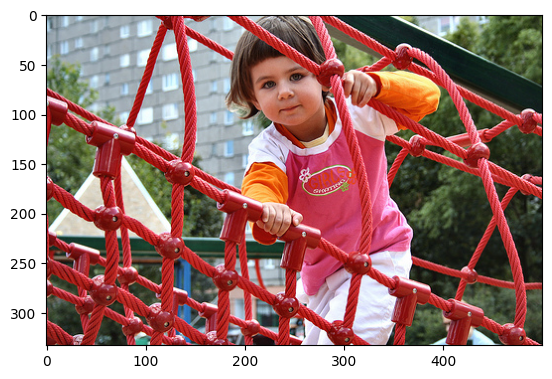

Cpation 0: A child playing on a rope net .
Cpation 1: A little girl climbing on red roping .
Cpation 2: A little girl in pink climbs a rope bridge at the park .
Cpation 3: A small child grips onto the red ropes at the playground .


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_index = 25
image_path = f"../input/flickr8k/Images/{df.iloc[data_index,0]}"
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(4):
    print(f'Cpation {i}: {df.iloc[data_index+i,1]}')

In [4]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [5]:
spacy_eng = spacy.load("en_core_web_sm")
text = "this is a, test to blah; blah 'yeahh'"
[token.text for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', ',', 'test', 'to', 'blah', ';', 'blah', "'", 'yeahh', "'"]

In [6]:
def build_vocab(text_list):
    itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
    stoi = {v:k for k,v in itos.items()}

    for text in text_list:
        for token in spacy_eng.tokenizer(text):
            token = token.text.lower()
            if token not in stoi:
                idx = len(stoi)
                stoi[token] = idx
                itos[idx] = token
    return itos, stoi

In [7]:
itos, stoi = build_vocab(["mary had a little lamb", 'itsy bitsy spider had'])
print(stoi)
print(itos)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'mary': 4, 'had': 5, 'a': 6, 'little': 7, 'lamb': 8, 'itsy': 9, 'bitsy': 10, 'spider': 11}
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'mary', 5: 'had', 6: 'a', 7: 'little', 8: 'lamb', 9: 'itsy', 10: 'bitsy', 11: 'spider'}


In [8]:
class FlickrDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.itos, self.stoi = build_vocab(df["caption"].tolist())
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"../input/flickr8k/Images/{row[0]}"
        caption = row['caption']
        img = Image.open(image_path).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.stoi["<SOS>"]]
        caption_vec += [self.stoi[token.text.lower()] for token in spacy_eng.tokenizer(caption)]
        caption_vec += [self.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)
        

/tmp/ipykernel_13/4114996556.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = f"../input/flickr8k/Images/{row[0]}"


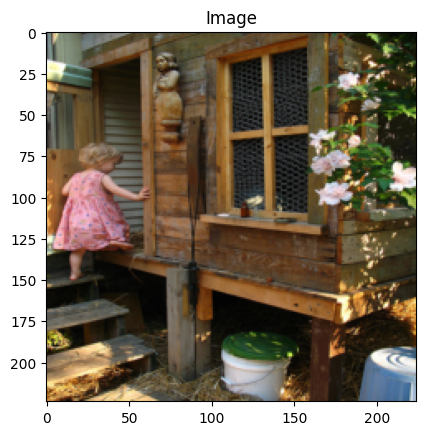

Token: tensor([ 1,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15, 16, 17,
        18,  2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<EOS>']


In [9]:
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 
dataset =  FlickrDataset(
    df,
    transform=transforms
)


img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.itos[token] for token in caps.tolist()])
